In [1]:
#https://github.com/TommasoStrada/Progetto-Data-Science-Lab

The XGBoost (eXtreme Gradient Boosting) is a popular and efficient open-source implementation of the gradient boosted trees algorithm. Gradient boosting is a supervised learning algorithm that attempts to accurately predict a target variable by combining an ensemble of estimates from a set of simpler and weaker models. The XGBoost algorithm performs well in machine learning competitions because of its robust handling of a variety of data types, relationships, distributions, and the variety of hyperparameters that you can fine-tune. You can use XGBoost for regression, classification (binary and multiclass), and ranking problems.

In [2]:
#!pip install xgboost 1.6

In [3]:
import math
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost

In [4]:
shift_giornaliero = 1       #giorno precedente
shift_settimanale = 7       #stesso giorno, settimana precedente

shift_scelto = shift_giornaliero

In [5]:
print("xgboost versione numero: ", xgboost.__version__)

xgboost versione numero:  0.90


In [6]:
repo_alessandro = "https://github.com/Alessandro-Fasani/DsLab/raw/main/serie-storiche-ecommerce-pulito-no-buchi-temporali.csv"
repo_team = ""

In [7]:
ds = pd.read_csv(repo_alessandro)

#**Esplorazione e pulizia Dataset**

In [8]:
ds.sample(5)

Unnamed: 0        data  new_index    totale  settore  Anno      Mese  \
10788       10788  2018-08-23    14507.0   2002.81  Fitness  2018    Agosto   
9444         9444  2014-12-18     2588.0   6576.89  Fitness  2014  Dicembre   
3468         3468  2015-03-14     3332.0   8368.21   Calcio  2015     Marzo   
9492         9492  2015-02-04     2984.0   5403.42  Fitness  2015  Febbraio   
7334         7334  2017-06-26    10709.0  10311.53   Casual  2017    Giugno   

       Giorno  Mese (n°)  
10788      23          8  
9444       18         12  
3468       14          3  
9492        4          2  
7334       26          6

In [9]:
ds = ds[["data", "settore", "totale"]]
ds.dtypes

data        object
settore     object
totale     float64
dtype: object

In [10]:
#Sistemiamo i tipi
ds["settore"] = ds.settore.astype("category")
ds['data'] = pd.to_datetime(ds['data'])
ds = ds[ds["data"] <= "2021-12-31"]
ds
#ds.dtypes

data  settore    totale
0     2014-01-01    Pesca      0.00
1     2014-01-02    Pesca      0.00
2     2014-01-03    Pesca      0.00
3     2014-01-04    Pesca      0.00
4     2014-01-05    Pesca      0.00
...          ...      ...       ...
15041 2021-12-27  Running      0.00
15042 2021-12-28  Running      0.00
15043 2021-12-29  Running  13715.95
15044 2021-12-30  Running  15645.36
15045 2021-12-31  Running   3247.51

[14610 rows x 3 columns]

In [11]:
ds.settore.unique()

['Pesca', 'Calcio', 'Casual', 'Fitness', 'Running']
Categories (5, object): ['Calcio', 'Casual', 'Fitness', 'Pesca', 'Running']

In [12]:
ds.sample(5)

data  settore    totale
8279  2020-01-27   Casual   5437.53
6290  2014-08-17   Casual   2392.51
14370 2020-02-25  Running   2401.52
8411  2020-06-07   Casual  20841.37
7711  2018-07-08   Casual  30152.99

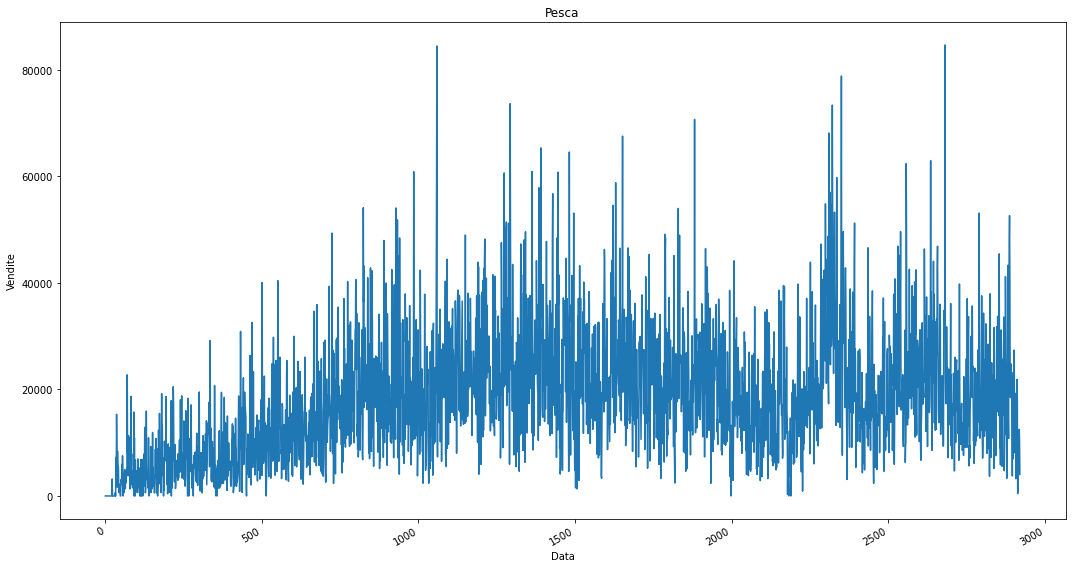

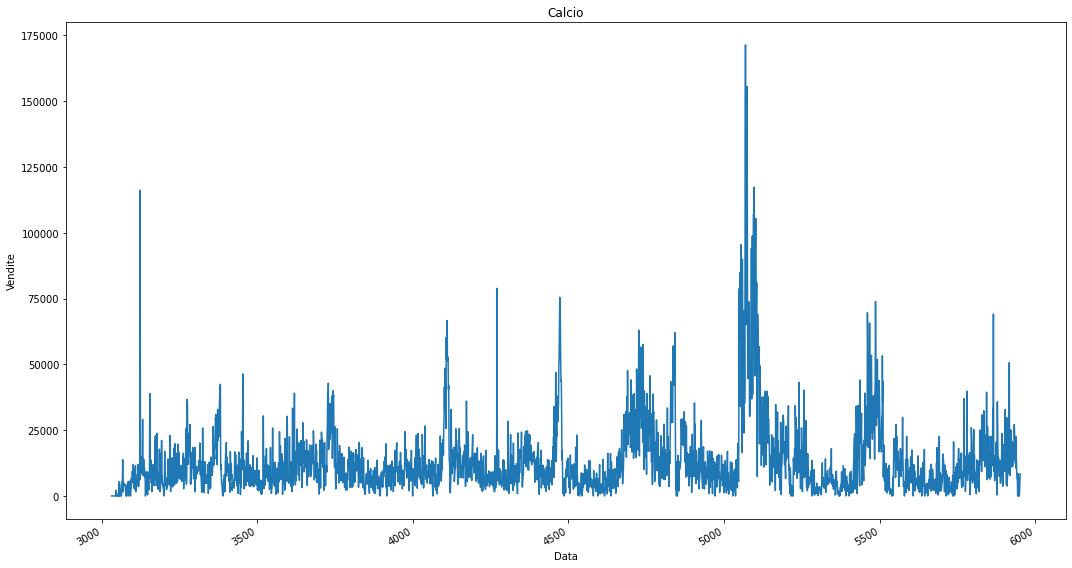

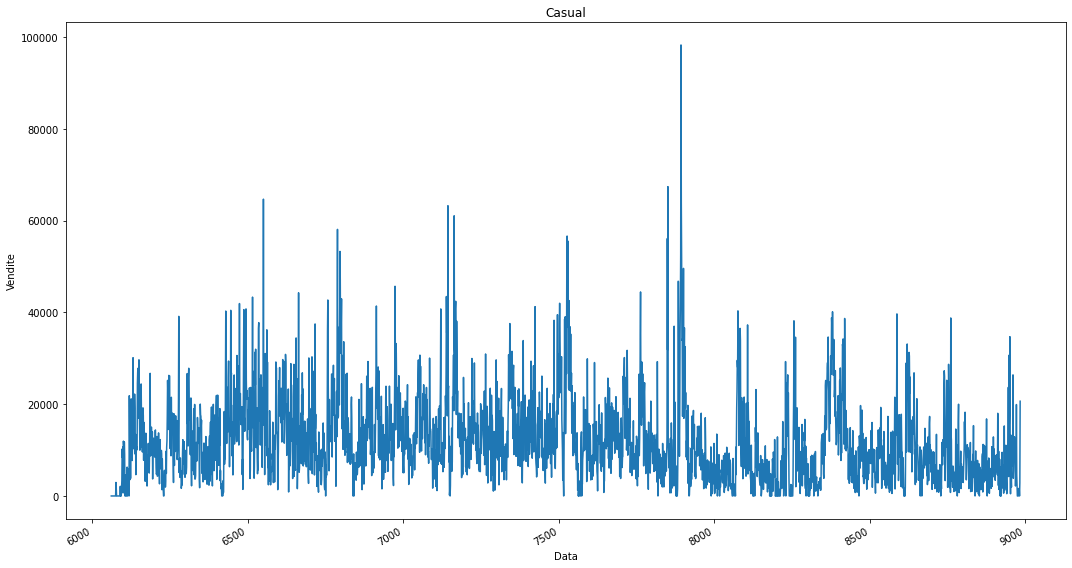

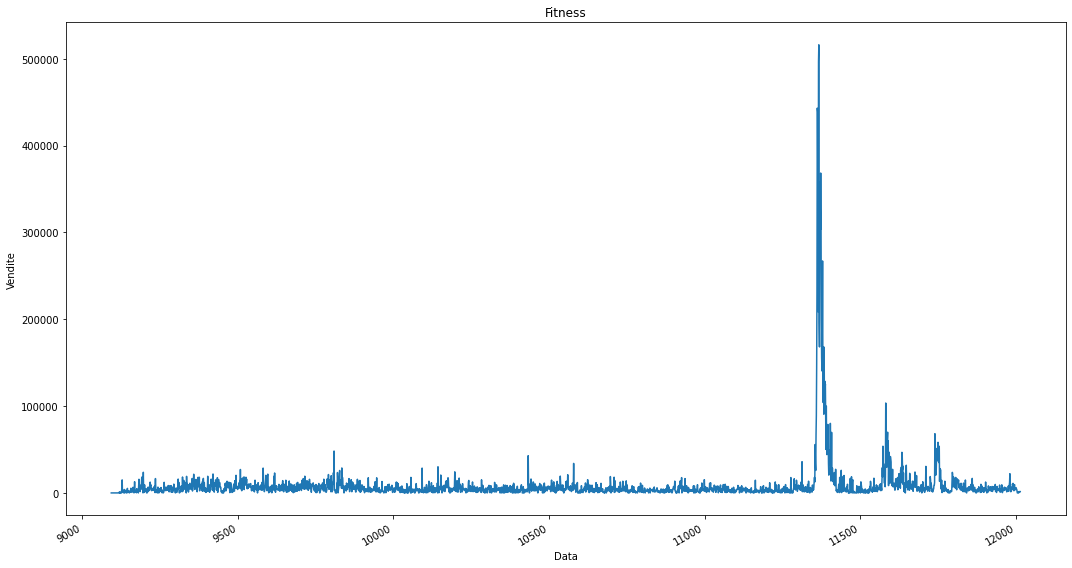

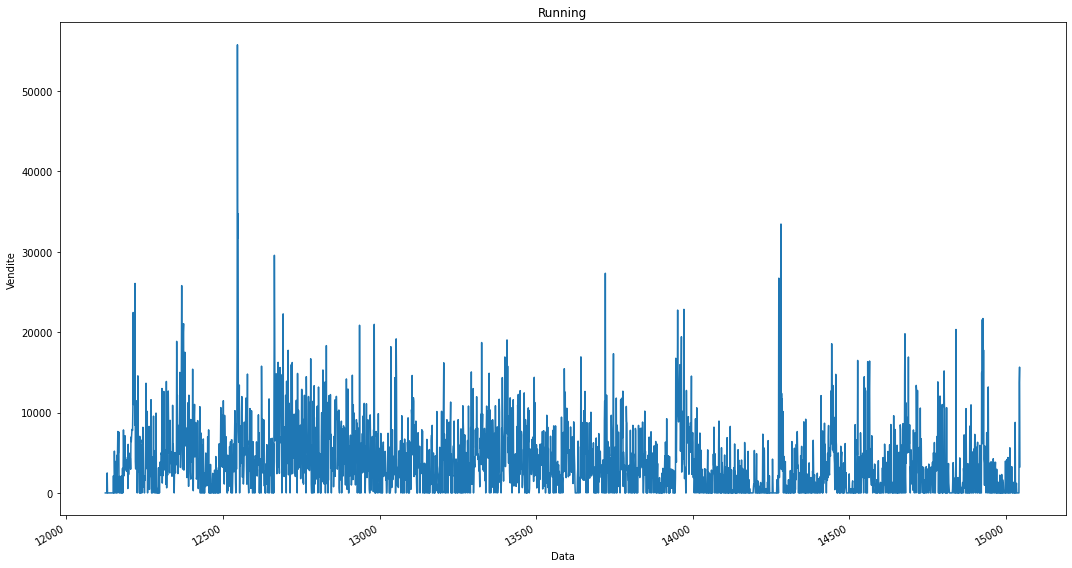

In [13]:
for categorie in ds.settore.unique():
  fig, ax = plt.subplots(figsize=(15, 8))
  ax.plot(ds[ds["settore"]==categorie]['totale'])
  ax.set_title(categorie)
  ax.set_xlabel('Data')
  ax.set_ylabel('Vendite')

  fig.autofmt_xdate()
  plt.tight_layout()
  plt.show()

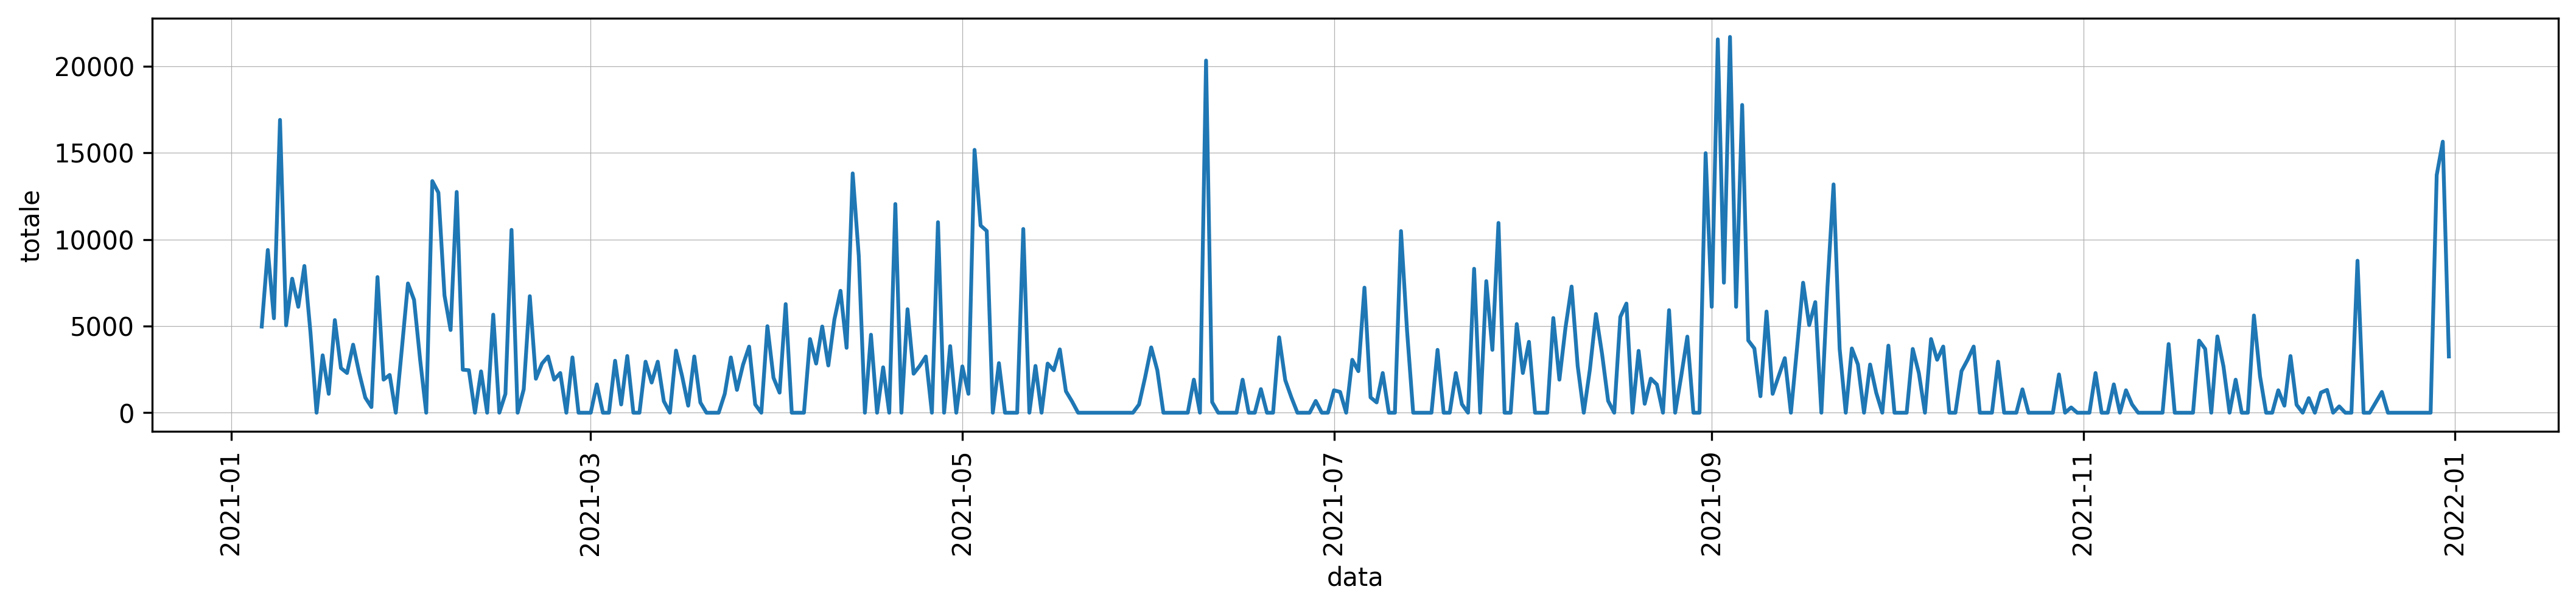

In [14]:
#IN ALTERNATIVA (ds[ds["settore"]==categorie]['totale']) <--NON funziona l'iterazione;settare un settore alla volta 
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds.tail(360), x='data', y='totale')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [15]:
#for categorie in ds.settore.unique():
#    
#    #Andamento annuale delle vendite per ogni settore sportivo
#    dv = ds[ds['settore'] == categorie].groupby(['Anno'], as_index = False).sum()[['Anno', 'totale']] #Visualizziamo solo queste in un dataframe nuovo
#
#    #Corpo della visualizzazione
#    plt.figure(figsize=(12,5))
#    x = dv['Anno'].to_list()
#    y = dv['totale'].to_list()
#
#    # Parte Estetica 
#    plt.xticks(x)
#    # plt.yticks(range(0,366,30))
#    plt.xlabel('Anni')
#    plt.ylabel('Totale Vendite')
#    plt.plot(x, y)
#    plt.title('Frequenze settore {} per anno'.format(categorie))
#    
#    # Mostra valori esatti del totale vendite per ogni osservazione (per ogni anno)
#    for i,j in zip(x,y):
#        plt.annotate(str(j),xy=(i,j))

#**Osservazioni sulle vendite giornaliere di prodotti dei settori Calcio, Pesca e Casual**


In [16]:
ds_calcio = ds[ds["settore"]== "Calcio"]
ds_pesca = ds[ds["settore"]== "Pesca"]
ds_casual =ds[ds["settore"]== "Casual"]

In [17]:
porzione_test = round(len(ds_calcio) * 0.2)       # 20% circa verra usato per il test 
porzione_test

584

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


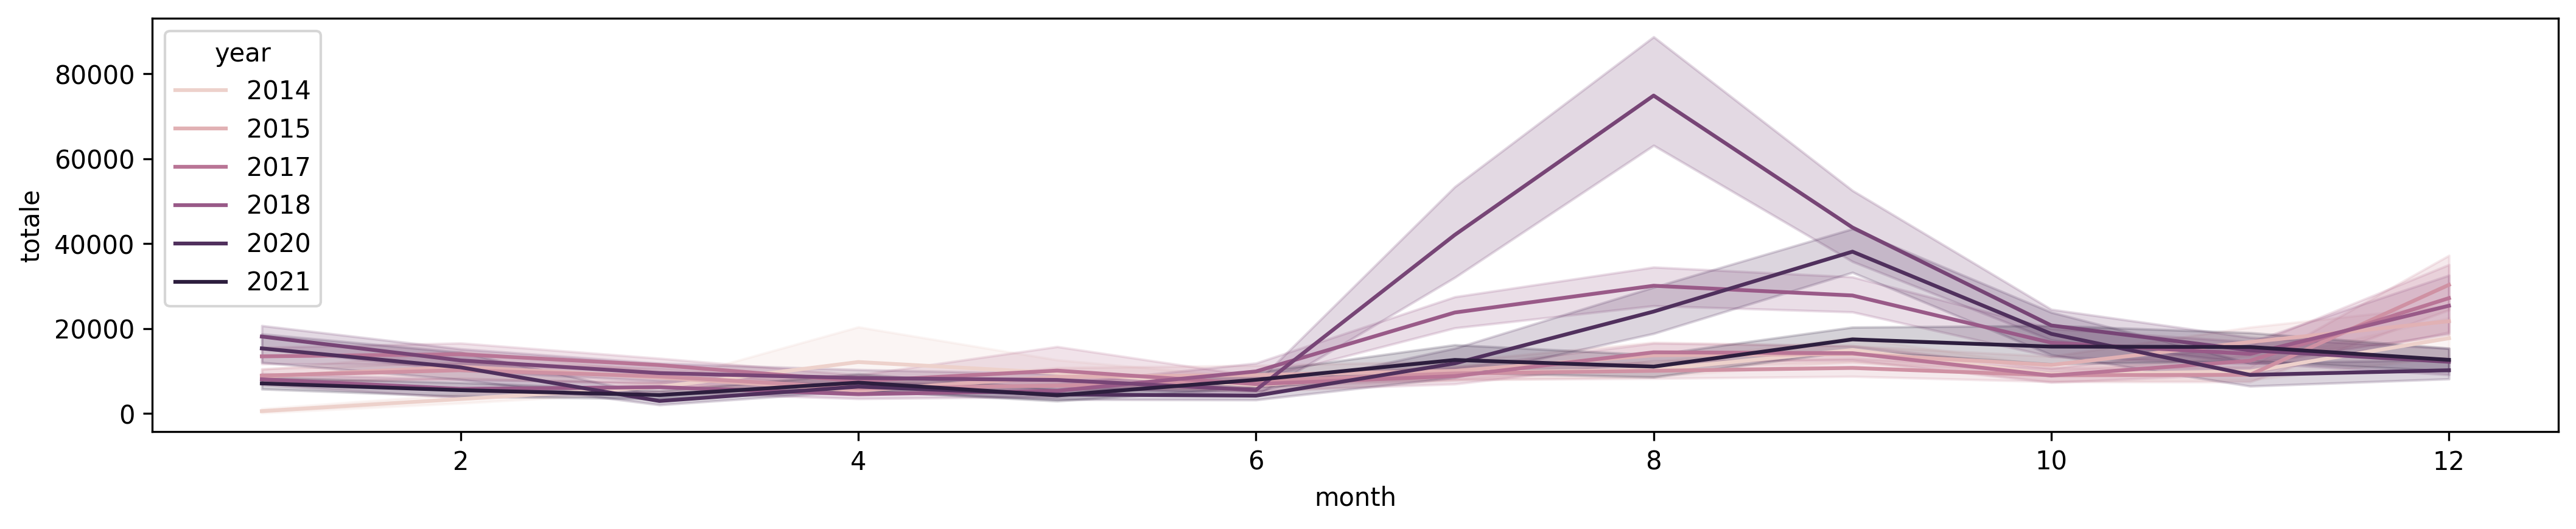

In [18]:
ds_calcio['month'] = ds_calcio['data'].dt.month
ds_calcio['year'] = ds_calcio['data'].dt.year
sns.lineplot(x= ds_calcio['month'], y= ds_calcio['totale'], hue=ds_calcio['year'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


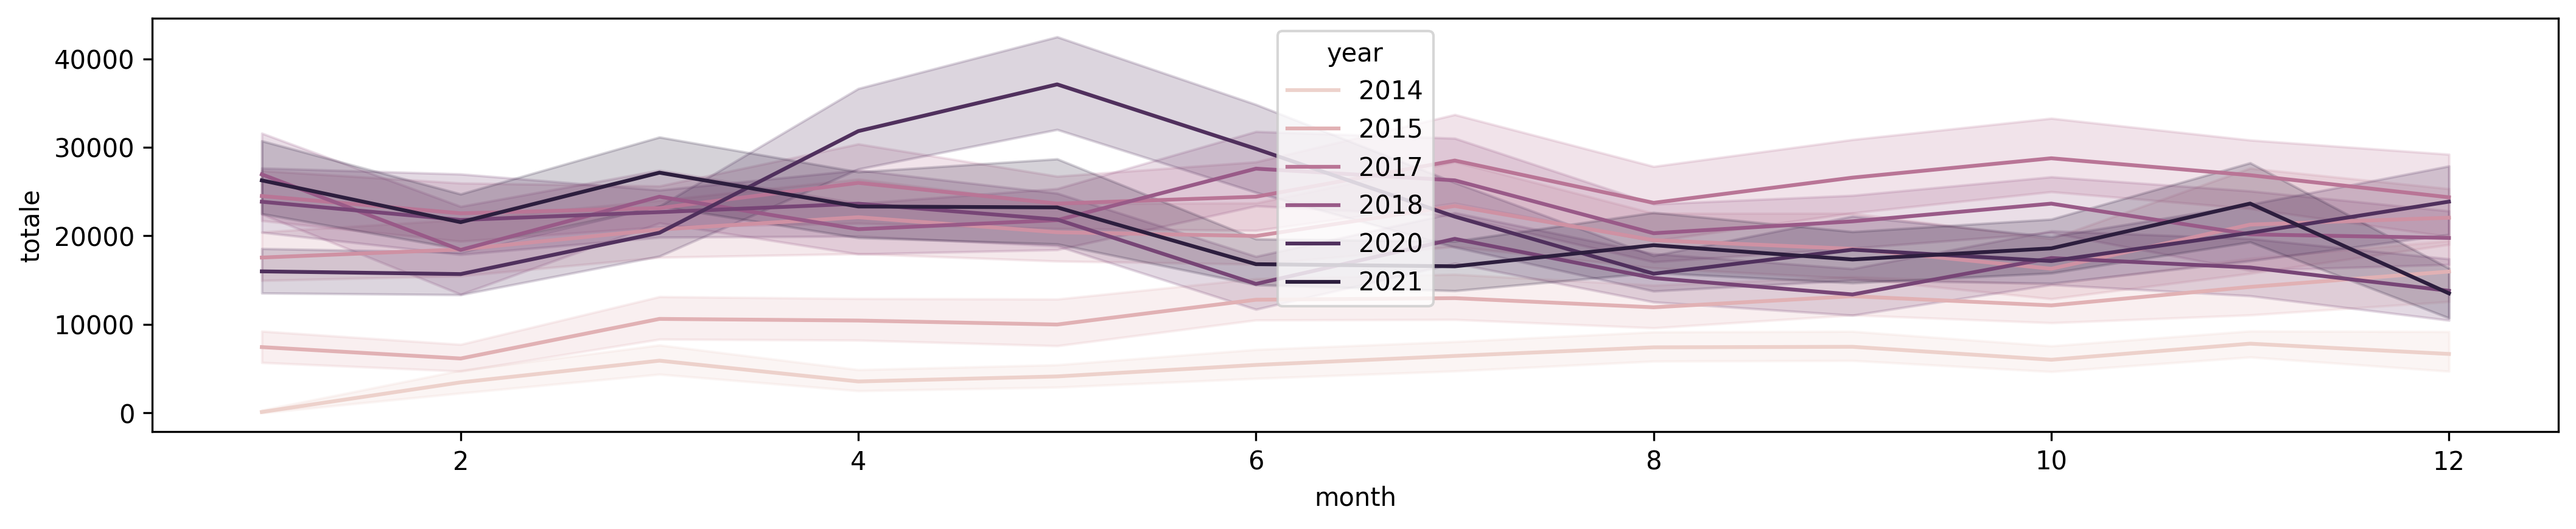

In [19]:
ds_pesca['month'] = ds_pesca['data'].dt.month
ds_pesca['year'] = ds_pesca['data'].dt.year
sns.lineplot(x= ds_pesca['month'], y= ds_pesca['totale'], hue=ds_pesca['year'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


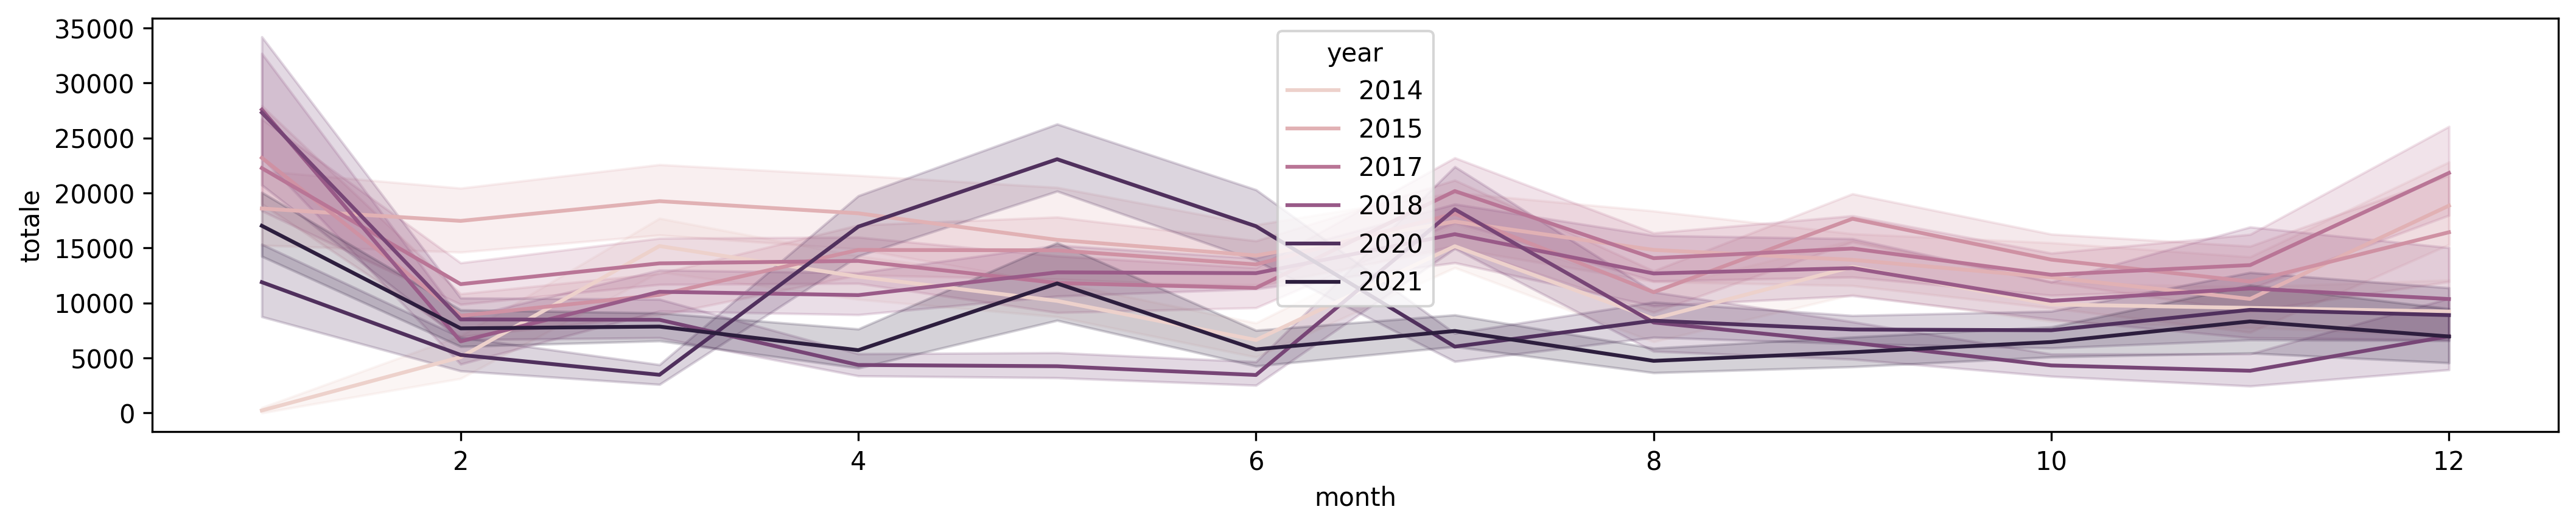

In [20]:
ds_casual['month'] = ds_casual['data'].dt.month
ds_casual['year'] = ds_casual['data'].dt.year
sns.lineplot(x= ds_casual['month'], y= ds_casual['totale'], hue=ds_casual['year'])

In [21]:
ds_calcio["totale_periodo_prec"] = ds_calcio["totale"].shift(+shift_scelto)
ds_pesca["totale_periodo_prec"] = ds_pesca["totale"].shift(+shift_scelto)
ds_casual["totale_periodo_prec"] = ds_casual["totale"].shift(+shift_scelto)

ds_calcio= ds_calcio.dropna()    
ds_pesca= ds_pesca.dropna()      
ds_casual= ds_casual.dropna()    

ds_calcio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

data settore   totale  month  year  totale_periodo_prec
3032 2014-01-02  Calcio     0.00      1  2014                 0.00
3033 2014-01-03  Calcio     0.00      1  2014                 0.00
3034 2014-01-04  Calcio     0.00      1  2014                 0.00
3035 2014-01-05  Calcio     0.00      1  2014                 0.00
3036 2014-01-06  Calcio     0.00      1  2014                 0.00
...         ...     ...      ...    ...   ...                  ...
5948 2021-12-27  Calcio  6877.08     12  2021                 0.00
5949 2021-12-28  Calcio     0.00     12  2021              6877.08
5950 2021-12-29  Calcio  1307.74     12  2021                 0.00
5951 2021-12-30  Calcio  4883.27     12  2021              1307.74
5952 2021-12-31  Calcio  8343.37     12  2021              4883.27

[2921 rows x 6 columns]

In [22]:
#LIST INPUT, divisione tra parte train e parte dedicata al test
x_calcio = ds_calcio[['totale_periodo_prec']]
x_pesca = ds_pesca[['totale_periodo_prec']]
x_casual = ds_casual[['totale_periodo_prec']]

x_calcio_to_train = x_calcio.iloc[:(len(x_calcio)-porzione_test)]
x_pesca_to_train = x_pesca.iloc[:(len(x_pesca)-porzione_test)]
x_casual_to_train = x_casual.iloc[:(len(x_casual)-porzione_test)]

x_calcio_to_test = x_calcio.iloc[(len(x_calcio)-porzione_test):]
x_pesca_to_test = x_pesca.iloc[(len(x_pesca)-porzione_test):]
x_casual_to_test = x_casual.iloc[(len(x_casual)-porzione_test):]


#LIST OUTPUT, divisione tra parte train e parte dedicata al test
y_calcio = ds_calcio[['totale']]
y_pesca = ds_pesca[['totale']]
y_casual = ds_casual[['totale']]

y_calcio_to_train = y_calcio.iloc[:(len(y_calcio)-porzione_test)]
y_pesca_to_train = y_pesca.iloc[:(len(y_pesca)-porzione_test)]
y_casual_to_train = y_casual.iloc[:(len(y_casual)-porzione_test)]

y_calcio_to_test = y_calcio.iloc[(len(y_calcio)-porzione_test):]
y_pesca_to_test = y_pesca.iloc[(len(y_pesca)-porzione_test):]
y_casual_to_test = y_casual.iloc[(len(y_casual)-porzione_test):]

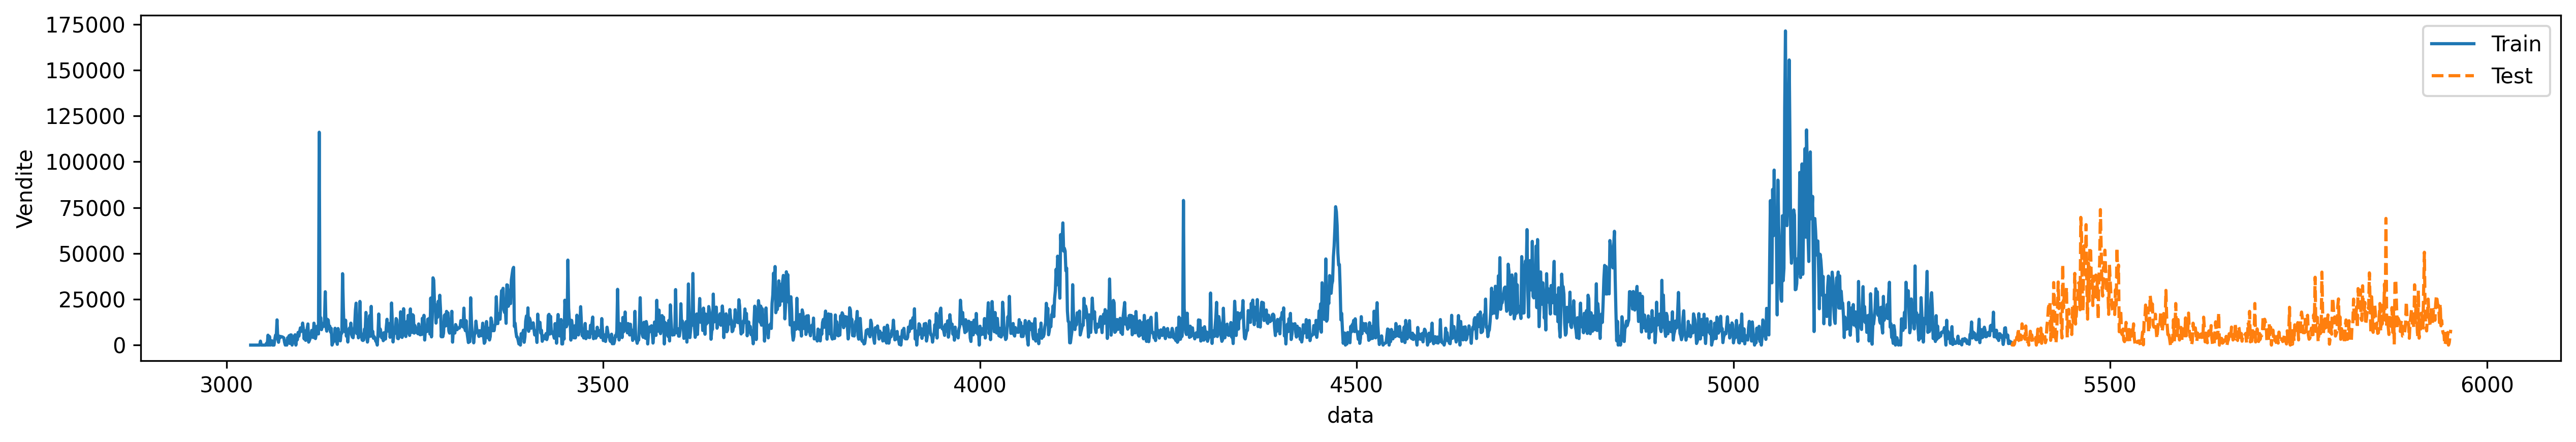

In [23]:

fig, ax = plt.subplots(figsize=(17, 3))
ax.plot(y_calcio_to_train, ls='-', label='Train')
ax.plot(y_calcio_to_test, ls='--', label='Test')
ax.set_xlabel('data')
ax.set_ylabel('Vendite')

ax.legend(loc='best')
plt.tight_layout()
plt.show()

In [24]:
estimator_calcio = XGBRegressor(objective='reg:squarederror', n_estimators=170, learning_rate=0.01)
estimator_pesca = XGBRegressor(objective='reg:squarederror', n_estimators=320, learning_rate=0.01)
estimator_casual = XGBRegressor(objective='reg:squarederror', n_estimators=130, learning_rate=0.01)

estimator_calcio.fit(x_calcio_to_train, y_calcio_to_train,
              eval_set=[(x_calcio_to_train, y_calcio_to_train), (x_calcio_to_test, y_calcio_to_test)],
              eval_metric='mae')

estimator_pesca.fit(x_pesca_to_train, y_pesca_to_train,
              eval_set=[(x_pesca_to_train, y_pesca_to_train), (x_pesca_to_test, y_pesca_to_test)],
              eval_metric='mae')

estimator_casual.fit(x_casual_to_train, y_casual_to_train,
              eval_set=[(x_casual_to_train, y_casual_to_train), (x_casual_to_test, y_casual_to_test)],
              eval_metric='mae')

[0]	validation_0-mae:13116.7	validation_1-mae:12311.9
[1]	validation_0-mae:12990.1	validation_1-mae:12191.9
[2]	validation_0-mae:12864.8	validation_1-mae:12074
[3]	validation_0-mae:12740.6	validation_1-mae:11955.5
[4]	validation_0-mae:12617.8	validation_1-mae:11840.5
[5]	validation_0-mae:12496.4	validation_1-mae:11725
[6]	validation_0-mae:12376.7	validation_1-mae:11612.6
[7]	validation_0-mae:12258.2	validation_1-mae:11501
[8]	validation_0-mae:12141.3	validation_1-mae:11391.4
[9]	validation_0-mae:12025.7	validation_1-mae:11282.4
[10]	validation_0-mae:11911.8	validation_1-mae:11176.9
[11]	validation_0-mae:11799.1	validation_1-mae:11071.2
[12]	validation_0-mae:11688	validation_1-mae:10968.3
[13]	validation_0-mae:11578.4	validation_1-mae:10866.5
[14]	validation_0-mae:11470.2	validation_1-mae:10766.6
[15]	validation_0-mae:11363.4	validation_1-mae:10666.7
[16]	validation_0-mae:11258.3	validation_1-mae:10569.6
[17]	validation_0-mae:11154.5	validation_1-mae:10476.4
[18]	validation_0-mae:11052	

XGBRegressor(learning_rate=0.01, n_estimators=130, objective='reg:squarederror')

In [25]:
predictions_calcio = estimator_calcio.predict(x_calcio_to_test)
predictions_pesca = estimator_pesca.predict(x_pesca_to_test)
predictions_casual = estimator_casual.predict(x_casual_to_test)

In [26]:
calcio_evalutation_ds = ds_calcio[(len(ds_calcio)-porzione_test):]   
calcio_evalutation_ds = calcio_evalutation_ds.reset_index().drop('index', axis=1)
calcio_evalutation_ds['predictions'] = pd.Series(predictions_calcio)

calcio_evalutation_ds

data settore   totale  month  year  totale_periodo_prec  predictions
0   2020-05-27  Calcio   466.66      5  2020              1738.37  4303.154297
1   2020-05-28  Calcio     0.00      5  2020               466.66  4281.738281
2   2020-05-29  Calcio  1238.97      5  2020                 0.00  4083.155029
3   2020-05-30  Calcio     0.00      5  2020              1238.97  4303.154297
4   2020-05-31  Calcio   627.67      5  2020                 0.00  4083.155029
..         ...     ...      ...    ...   ...                  ...          ...
579 2021-12-27  Calcio  6877.08     12  2021                 0.00  4083.155029
580 2021-12-28  Calcio     0.00     12  2021              6877.08  7861.924805
581 2021-12-29  Calcio  1307.74     12  2021                 0.00  4083.155029
582 2021-12-30  Calcio  4883.27     12  2021              1307.74  4303.154297
583 2021-12-31  Calcio  8343.37     12  2021              4883.27  5980.479980

[584 rows x 7 columns]

In [27]:
pesca_evalutation_ds = ds_pesca[(len(ds_pesca)-porzione_test):]  
pesca_evalutation_ds = pesca_evalutation_ds.reset_index().drop('index', axis=1)
pesca_evalutation_ds['predictions'] = pd.Series(predictions_pesca)

pesca_evalutation_ds

data settore    totale  month  year  totale_periodo_prec  \
0   2020-05-27   Pesca  23544.17      5  2020             35006.79   
1   2020-05-28   Pesca  15433.86      5  2020             23544.17   
2   2020-05-29   Pesca  16905.34      5  2020             15433.86   
3   2020-05-30   Pesca  13823.20      5  2020             16905.34   
4   2020-05-31   Pesca  29171.92      5  2020             13823.20   
..         ...     ...       ...    ...   ...                  ...   
579 2021-12-27   Pesca   7589.89     12  2021              4216.03   
580 2021-12-28   Pesca   5964.50     12  2021              7589.89   
581 2021-12-29   Pesca  12495.55     12  2021              5964.50   
582 2021-12-30   Pesca  10174.53     12  2021             12495.55   
583 2021-12-31   Pesca   4036.19     12  2021             10174.53   

      predictions  
0    22136.369141  
1    22230.441406  
2    17344.167969  
3    18024.910156  
4    17566.693359  
..            ...  
579   9432.813477  
580  12017.876953  
581  10518.407227  
582  17276.169922  
583  15037.433594  

[584 rows x 7 columns]

In [28]:
casual_evalutation_ds = ds_casual[(len(ds_casual)-porzione_test):]  
casual_evalutation_ds = casual_evalutation_ds.reset_index().drop('index', axis=1)
casual_evalutation_ds['predictions'] = pd.Series(predictions_casual)

casual_evalutation_ds

data settore    totale  month  year  totale_periodo_prec  \
0   2020-05-27  Casual  12519.01      5  2020              8921.10   
1   2020-05-28  Casual  20601.77      5  2020             12519.01   
2   2020-05-29  Casual  13891.70      5  2020             20601.77   
3   2020-05-30  Casual  25171.48      5  2020             13891.70   
4   2020-05-31  Casual  13652.10      5  2020             25171.48   
..         ...     ...       ...    ...   ...                  ...   
579 2021-12-27  Casual   1309.65     12  2021              1635.76   
580 2021-12-28  Casual   1526.33     12  2021              1309.65   
581 2021-12-29  Casual      0.00     12  2021              1526.33   
582 2021-12-30  Casual   2822.60     12  2021                 0.00   
583 2021-12-31  Casual  20640.25     12  2021              2822.60   

      predictions  
0     8546.218750  
1     9289.224609  
2    13602.403320  
3     9289.224609  
4    15796.994141  
..            ...  
579   4332.612305  
580   4332.612305  
581   4332.612305  
582   1818.394531  
583   4955.142578  

[584 rows x 7 columns]

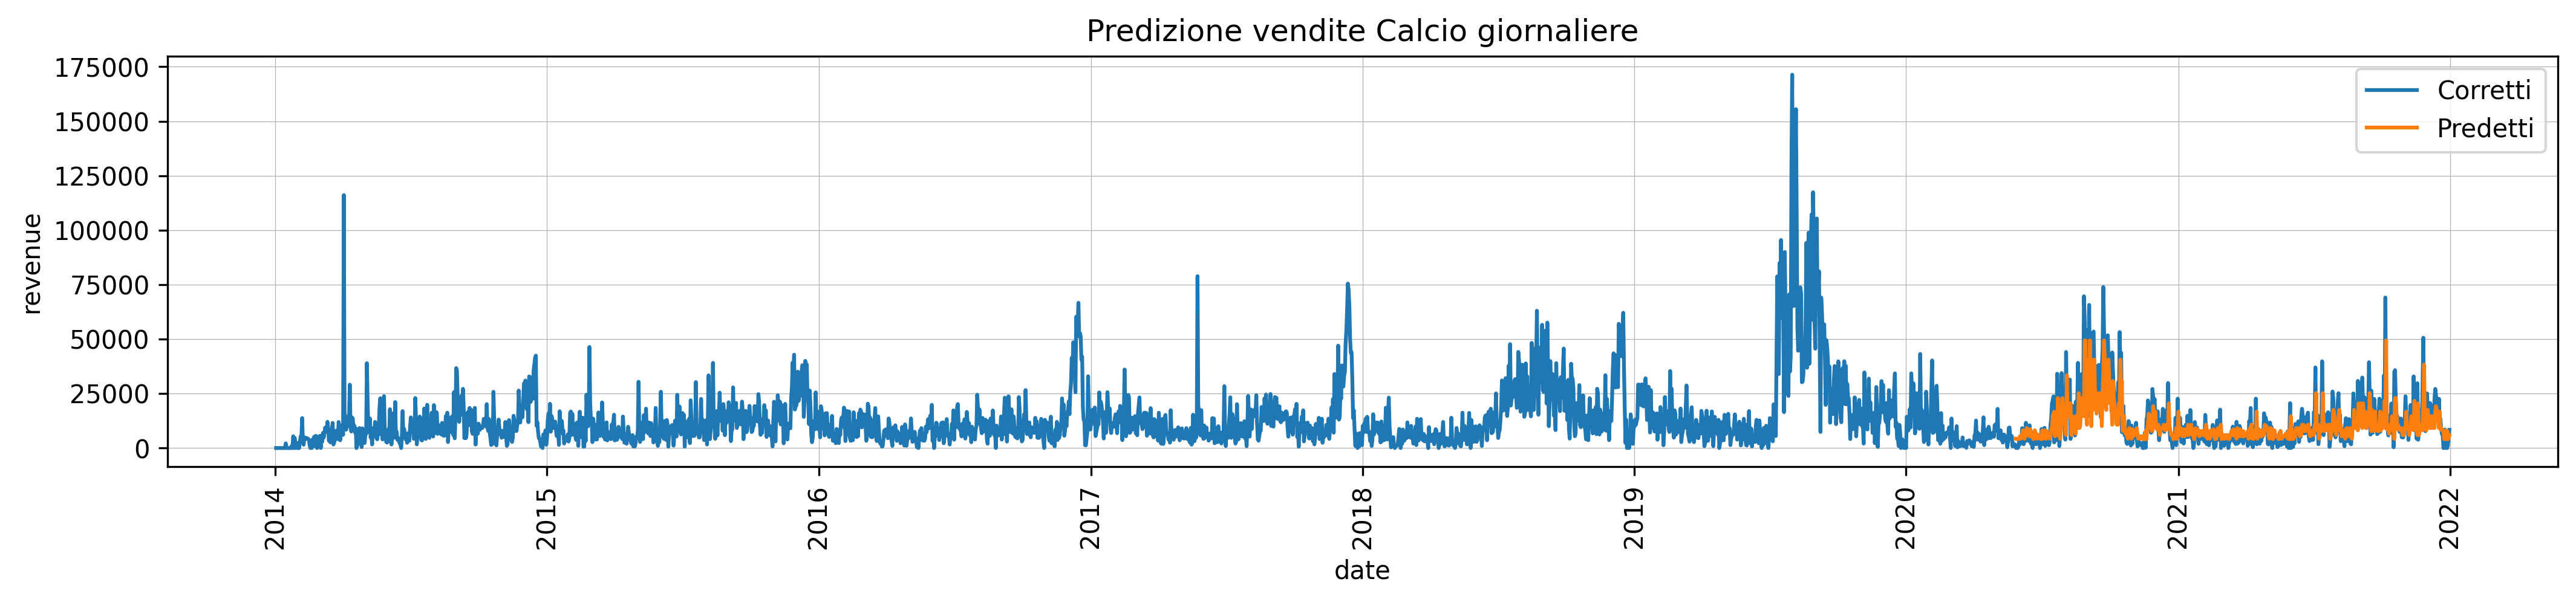

In [29]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_calcio, x= "data", y='totale', label= "Corretti" )     #_evalutation
sns.lineplot(data=calcio_evalutation_ds, x='data', y='predictions', palette= "red",  label= "Predetti")

#x = calcio_evalutation_ds['year']  
#y = calcio_evalutation_ds['predictions']
#for i,j in zip(x,y):
#  plt.annotate(str(j),xy=(i,j))
#
#y1 = calcio_evalutation_ds['revenue']
#for i,j in zip(x,y1):
#  plt.annotate(str(j),xy=(i,j))
#  calcio_evalutation_ds

plt.title("Predizione vendite Calcio giornaliere")
plt.xlabel ("date")
plt.ylabel ("revenue")

plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

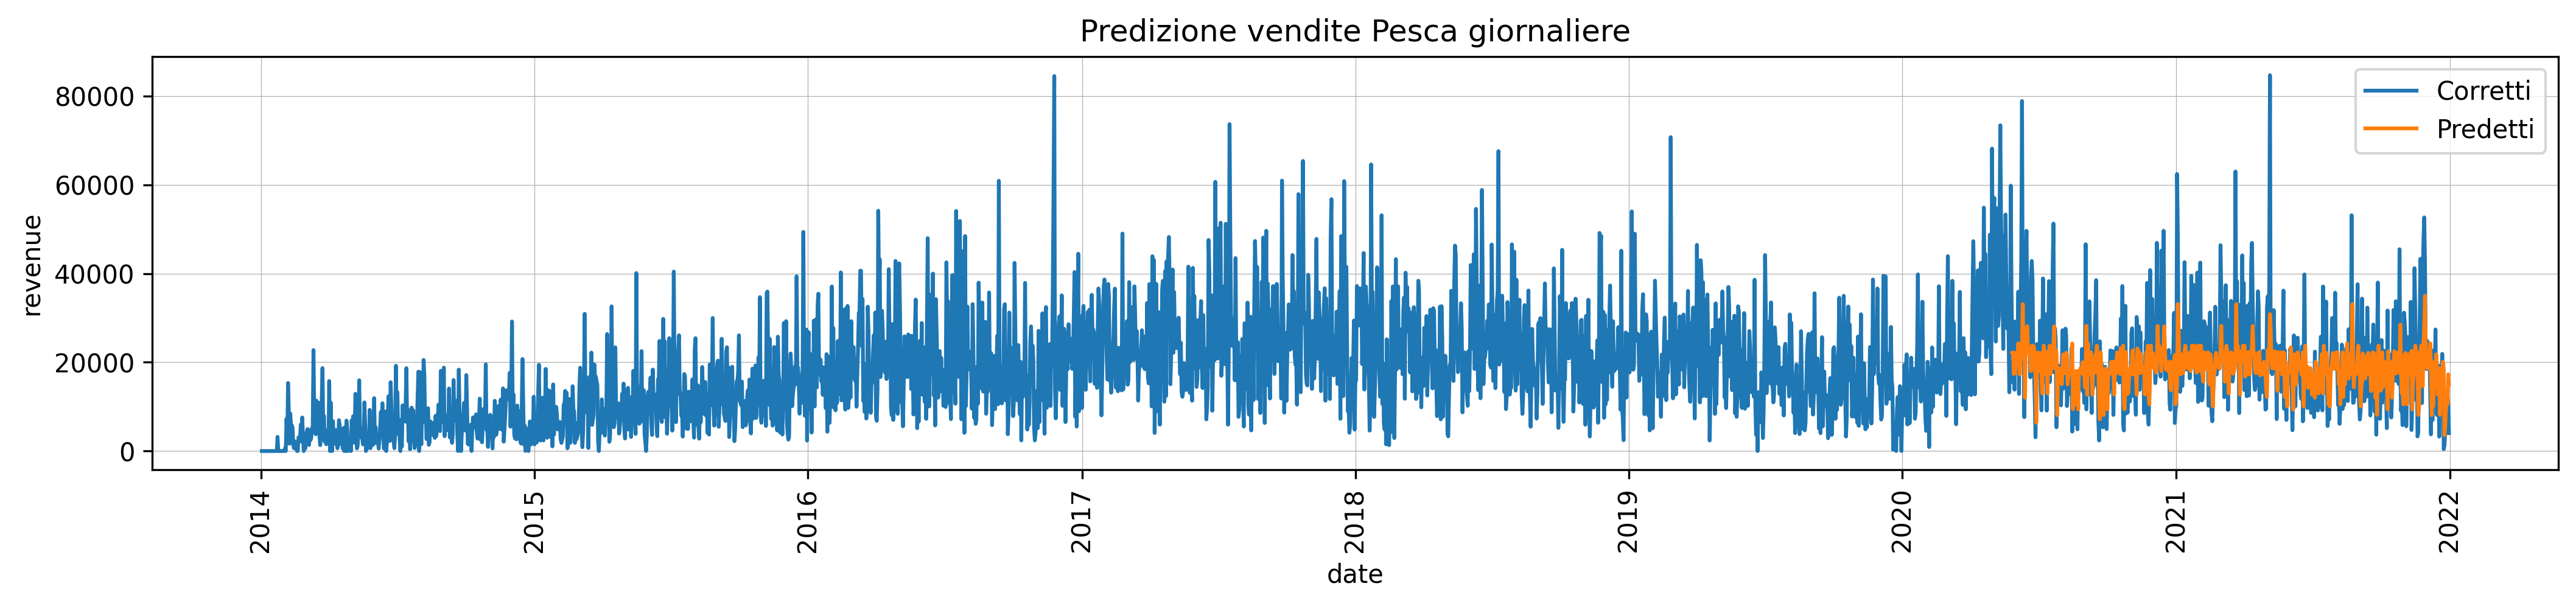

In [30]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_pesca, x= "data", y='totale', label= "Corretti")     
sns.lineplot(data=pesca_evalutation_ds, x='data', y='predictions', palette= "red", label= "Predetti") 

#x = pesca_evalutation_ds['year']  
#y = pesca_evalutation_ds['predictions']
#for i,j in zip(x,y):
#  plt.annotate(str(j),xy=(i,j))
#
#y1 = pesca_evalutation_ds['revenue']
#for i,j in zip(x,y1):
#  plt.annotate(str(j),xy=(i,j))
#  pesca_evalutation_ds

plt.title("Predizione vendite Pesca giornaliere")
plt.xlabel ("date")
plt.ylabel ("revenue")

plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

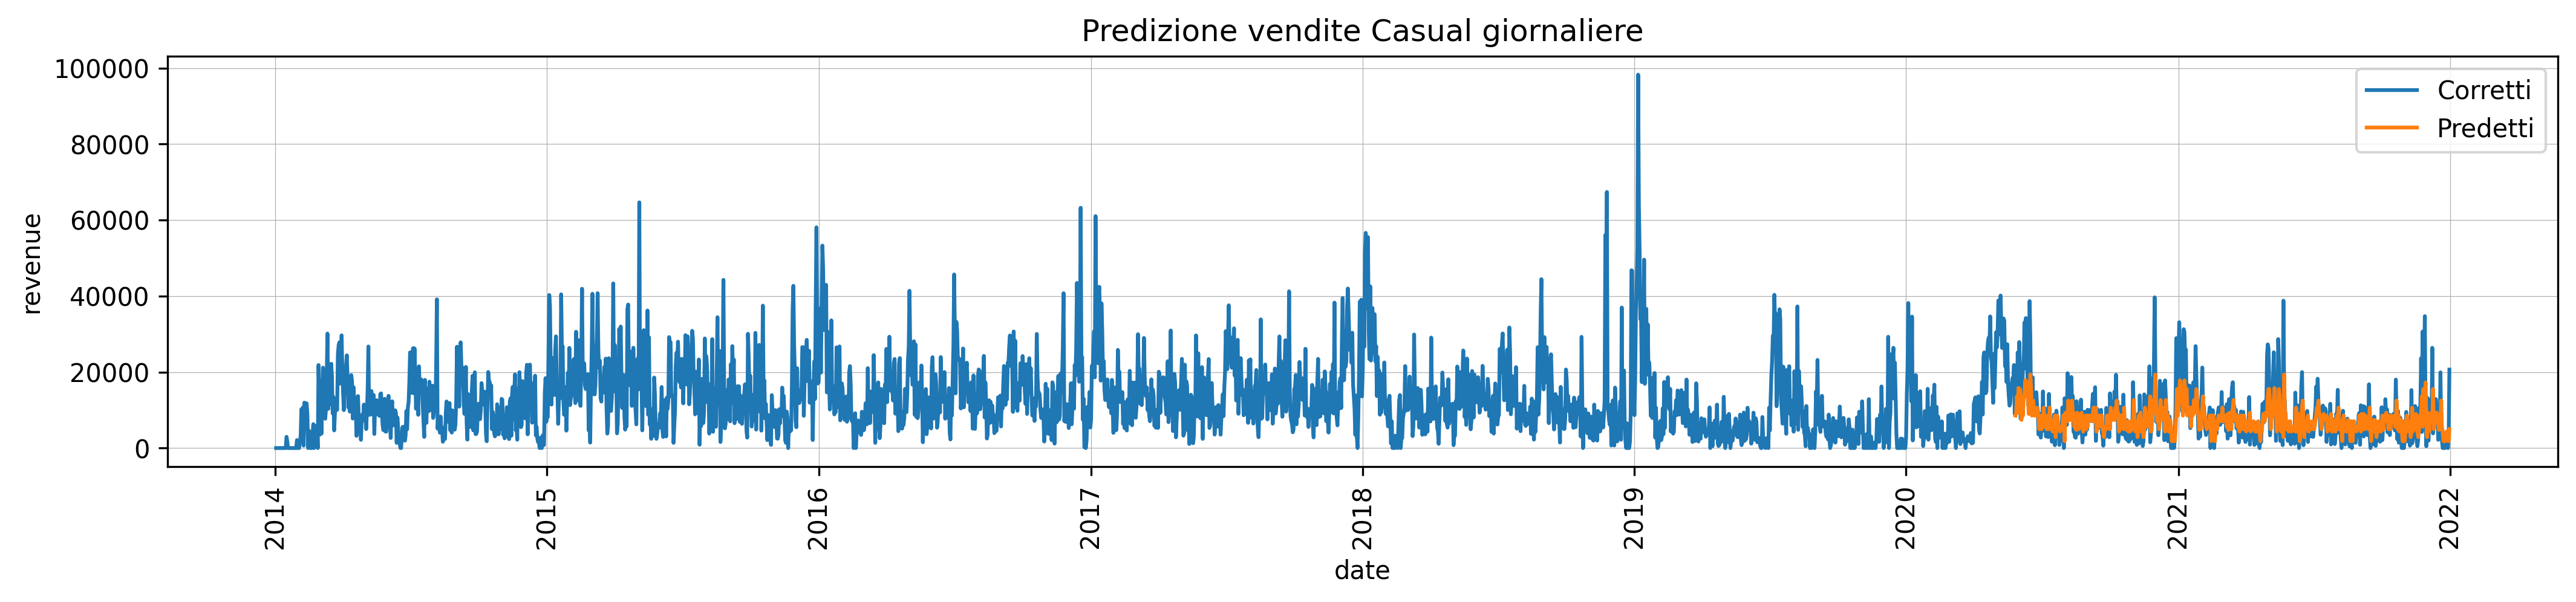

In [31]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_casual, x= "data", y='totale', label= "Corretti")     
sns.lineplot(data=casual_evalutation_ds, x='data', y='predictions', palette= "red", label= "Predetti") 

#x = casual_evalutation_ds['year']  
#y = casual_evalutation_ds['predictions']
#for i,j in zip(x,y):
#  plt.annotate(str(j),xy=(i,j))
#
#y1 = casual_evalutation_ds['revenue']
#for i,j in zip(x,y1):
#  plt.annotate(str(j),xy=(i,j))
#  casual_evalutation_ds

plt.title("Predizione vendite Casual giornaliere")
plt.xlabel ("date")
plt.ylabel ("revenue")

plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [32]:
calcio_evalutation_ds = calcio_evalutation_ds[calcio_evalutation_ds["totale"] != 0]
pesca_evalutation_ds = pesca_evalutation_ds[pesca_evalutation_ds["totale"] != 0]
casual_evalutation_ds = casual_evalutation_ds[casual_evalutation_ds["totale"] != 0]

In [33]:
print('Calcio XgBoost Mean Absolute Error (MAE): ', np.mean(np.abs(calcio_evalutation_ds["totale"] - calcio_evalutation_ds["predictions"])))

Calcio XgBoost Mean Absolute Error (MAE):  6356.231789761767


In [34]:
print('Pesca XgBoost Mean Absolute Error (MAE): ', np.mean(np.abs(pesca_evalutation_ds["totale"] - pesca_evalutation_ds["predictions"])))

Pesca XgBoost Mean Absolute Error (MAE):  7805.48825762187


In [35]:
print('Casual XgBoost Mean Absolute Error (MAE): ', np.mean(np.abs(casual_evalutation_ds["totale"] - casual_evalutation_ds["predictions"])))

Casual XgBoost Mean Absolute Error (MAE):  4442.9533905072585


In [36]:
MAEoneDayCalcio = 6075.912374948432
MAEoneDayPesca = 7631.582810743476
MAEoneDayCasual = 4286.313418468311

In [37]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [38]:
#print('Seasonality error reduction: ', (((np.mean(np.abs(calcio_evalutation_ds["totale"] - calcio_evalutation_ds["predictions"])))/MAEoneDayCalcio)-1)*100    )

In [39]:
print('Calcio XgBoost Mean Absolute Percentage Error (MAPE): ', mean_absolute_percentage_error(calcio_evalutation_ds["totale"], calcio_evalutation_ds["predictions"]))

Calcio XgBoost Mean Absolute Percentage Error (MAPE):  108.03715979880253


In [40]:
#print('Seasonality error reduction: ', (((np.mean(np.abs(pesca_evalutation_ds["totale"] - pesca_evalutation_ds["predictions"])))/MAEoneDayPesca)-1)*100     )

In [41]:
print('Pesca XgBoost Mean Absolute Percentage Error (MAPE): ', mean_absolute_percentage_error(pesca_evalutation_ds["totale"], pesca_evalutation_ds["predictions"]))

Pesca XgBoost Mean Absolute Percentage Error (MAPE):  56.55826186904296


In [42]:
#print('Seasonality error reduction: ', (((np.mean(np.abs(casual_evalutation_ds["totale"] - casual_evalutation_ds["predictions"])))/MAEoneDayCasual)-1)*100     )

In [43]:
print('Casual XgBoost Mean Absolute Percentage Error (MAPE): ', mean_absolute_percentage_error(casual_evalutation_ds["totale"], casual_evalutation_ds["predictions"]))

Casual XgBoost Mean Absolute Percentage Error (MAPE):  97.72975590592378


(Calcio migliore intorno ai 170)
(Pesca migliore intorno ai 320)
(Casual migliore intorno ai 130)




Con shift +1 giorno

* Calcio XgBoost Mean Absolute Error (MAE):  6356.23
* Pesca XgBoost Mean Absolute Error (MAE):  7805.48
* Casual XgBoost Mean Absolute Error (MAE):  4442.95


* Calcio XgBoost Mean Absolute Percentage Error (MAPE):  108.04 %
* Pesca XgBoost Mean Absolute Percentage Error (MAPE):  56.56 % 
* Casual XgBoost Mean Absolute Percentage Error (MAPE):  97.73 %



Con shift +7 giorni

* Calcio XgBoost Mean Absolute Error (MAE):  7043.73
* Pesca XgBoost Mean Absolute Error (MAE):  7943.06
* Casual XgBoost Mean Absolute Error (MAE):  4742.05


* Calcio XgBoost Mean Absolute Percentage Error (MAPE):  119.39 %
* Pesca XgBoost Mean Absolute Percentage Error (MAPE):  58.99 % 
* Casual XgBoost Mean Absolute Percentage Error (MAPE):  115.29 %




Ogni tentativo di introdurre stagionalità ha portato ad un peggiormaneto delle predizioni rispetto al MAE dello Shift giornaliero